/var/folders/nn/rjk_sthj67g1rcv7qxd8_14m0000gn/T/ipykernel_8064/604466959.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S_df['sigma_t'] = S_df['r_t'].rolling(window = window).std().fillna(method = 'bfill')



Bounded Sentiment Oscillator, rising during bullish momentum and fading under volatility stress:
          S_t       r_t   sigma_t       m_t       v_t     psi_t     phi_t  \
0  100.000000  0.000000  0.000748  0.000000  0.000000  0.000000  0.000000   
1   99.990495 -0.000095  0.000748 -0.000050  0.000053 -0.000204 -0.000204   
2  100.040695  0.000502  0.000748  0.000154  0.000237  0.000126  0.000126   
3  100.157490  0.001167  0.000748  0.000448  0.000552  0.000543  0.000543   
4  100.140677 -0.000168  0.000748  0.000298  0.000438  0.000272  0.000272   
5  100.123867 -0.000168  0.000748  0.000198  0.000365  0.000090  0.000090   
6  100.245037  0.001209  0.000748  0.000392  0.000578  0.000356  0.000356   
7  100.304488  0.000593  0.000748  0.000427  0.000582  0.000448  0.000448   
8  100.269726 -0.000347  0.000748  0.000301  0.000528  0.000169  0.000169   
9  100.312056  0.000422  0.000748  0.000320  0.000504  0.000249  0.000249   

      atso_t  
0  50.000000  
1  29.454354  
2  63.237

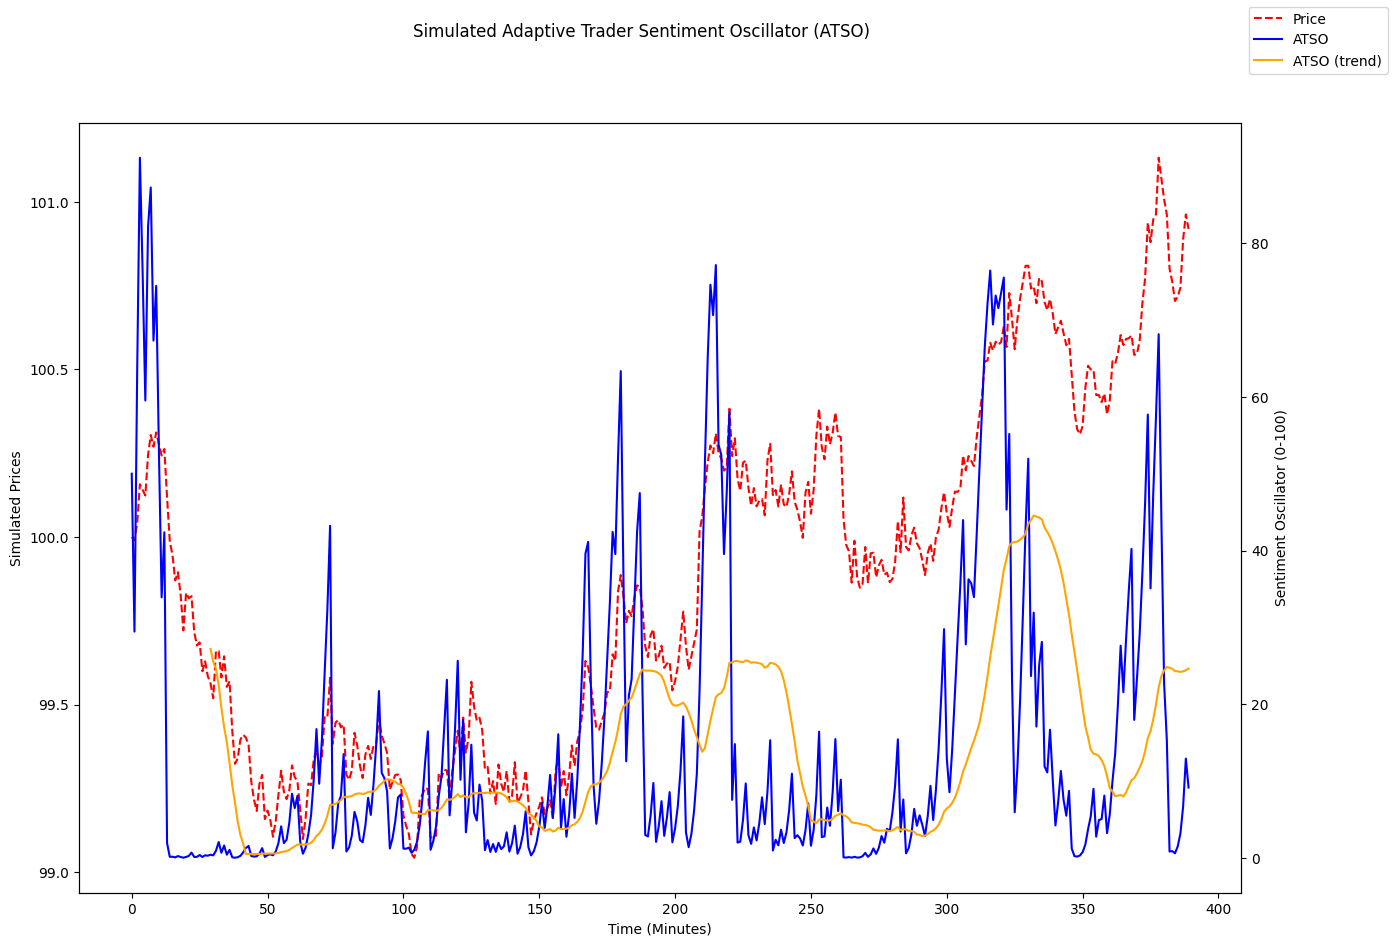

In [63]:
# --- Adaptive Trader Sentiment Oscillator ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Price Process Parameters ---
S0 = 100
mu = 0.004
sigma = 0.015
T = 1

# --- Simulation Parameters ---

np.random.seed(42)
n_simulations = 1
n_steps = 390
dt = T / n_steps

# --- Price Process Construction ---

dW = np.random.standard_normal(size = (n_steps, n_simulations))
S = np.zeros((n_steps, n_simulations))

for i in range(n_simulations):
    S[0, i] = S0
    for t in range(1, n_steps):
        S[t, i] = S[t - 1, i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[t, i])

S_df = pd.DataFrame(S, columns = ['S_t'])

# --- Returns Calculation ---

S_df['r_t'] = np.log(S_df['S_t']).diff(1)

S_df = S_df.fillna(0)

# --- Rolling Volatility Calculation ---

window = 15

S_df['sigma_t'] = S_df['r_t'].rolling(window = window).std().fillna(method = 'bfill')

# --- EWMA Momentum and Volatility Pressure Caclculation ---

lambda_m = 0.10
lambda_v = 0.20

S_df['m_t'] = S_df['r_t'].ewm(alpha = lambda_m).mean()
S_df['v_t'] = abs(S_df['r_t']).ewm(alpha = lambda_v).mean()

# --- Raw Sentiment Derivation ---

alpha = 2.75
beta = 1.25

S_df['psi_t'] = alpha * S_df['m_t'] - beta * S_df['v_t']

# --- Adaptive Adjustment Derivation ---

gamma = 3.5
sigma_bar = S_df['sigma_t'].mean()

S_df['phi_t'] = S_df['psi_t'] * (1 - gamma * abs(S_df['sigma_t'] - sigma_bar))

# --- ATSO_t Calculation ---

S_df['atso_t'] = 50 * (1 + np.tanh(S_df['phi_t'] / S_df['phi_t'].std()))

print('\nBounded Sentiment Oscillator, rising during bullish momentum and fading under volatility stress:')
print(S_df.head(10))

fig, ax1 = plt.subplots(figsize = (15, 10));
ax2 = ax1.twinx();
ax1.plot(S, '--', color = 'red', label = 'Price');
ax2.plot(S_df['atso_t'], color = 'blue', label = 'ATSO');
ax2.plot(S_df['atso_t'].rolling(30).mean(), color='orange', label='ATSO (trend)');
ax1.set_xlabel('Time (Minutes)');
ax1.set_ylabel('Simulated Prices');
ax2.set_ylabel('Sentiment Oscillator (0-100)');
fig.suptitle('Simulated Adaptive Trader Sentiment Oscillator (ATSO)');
fig.legend(loc = 'upper right');